<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

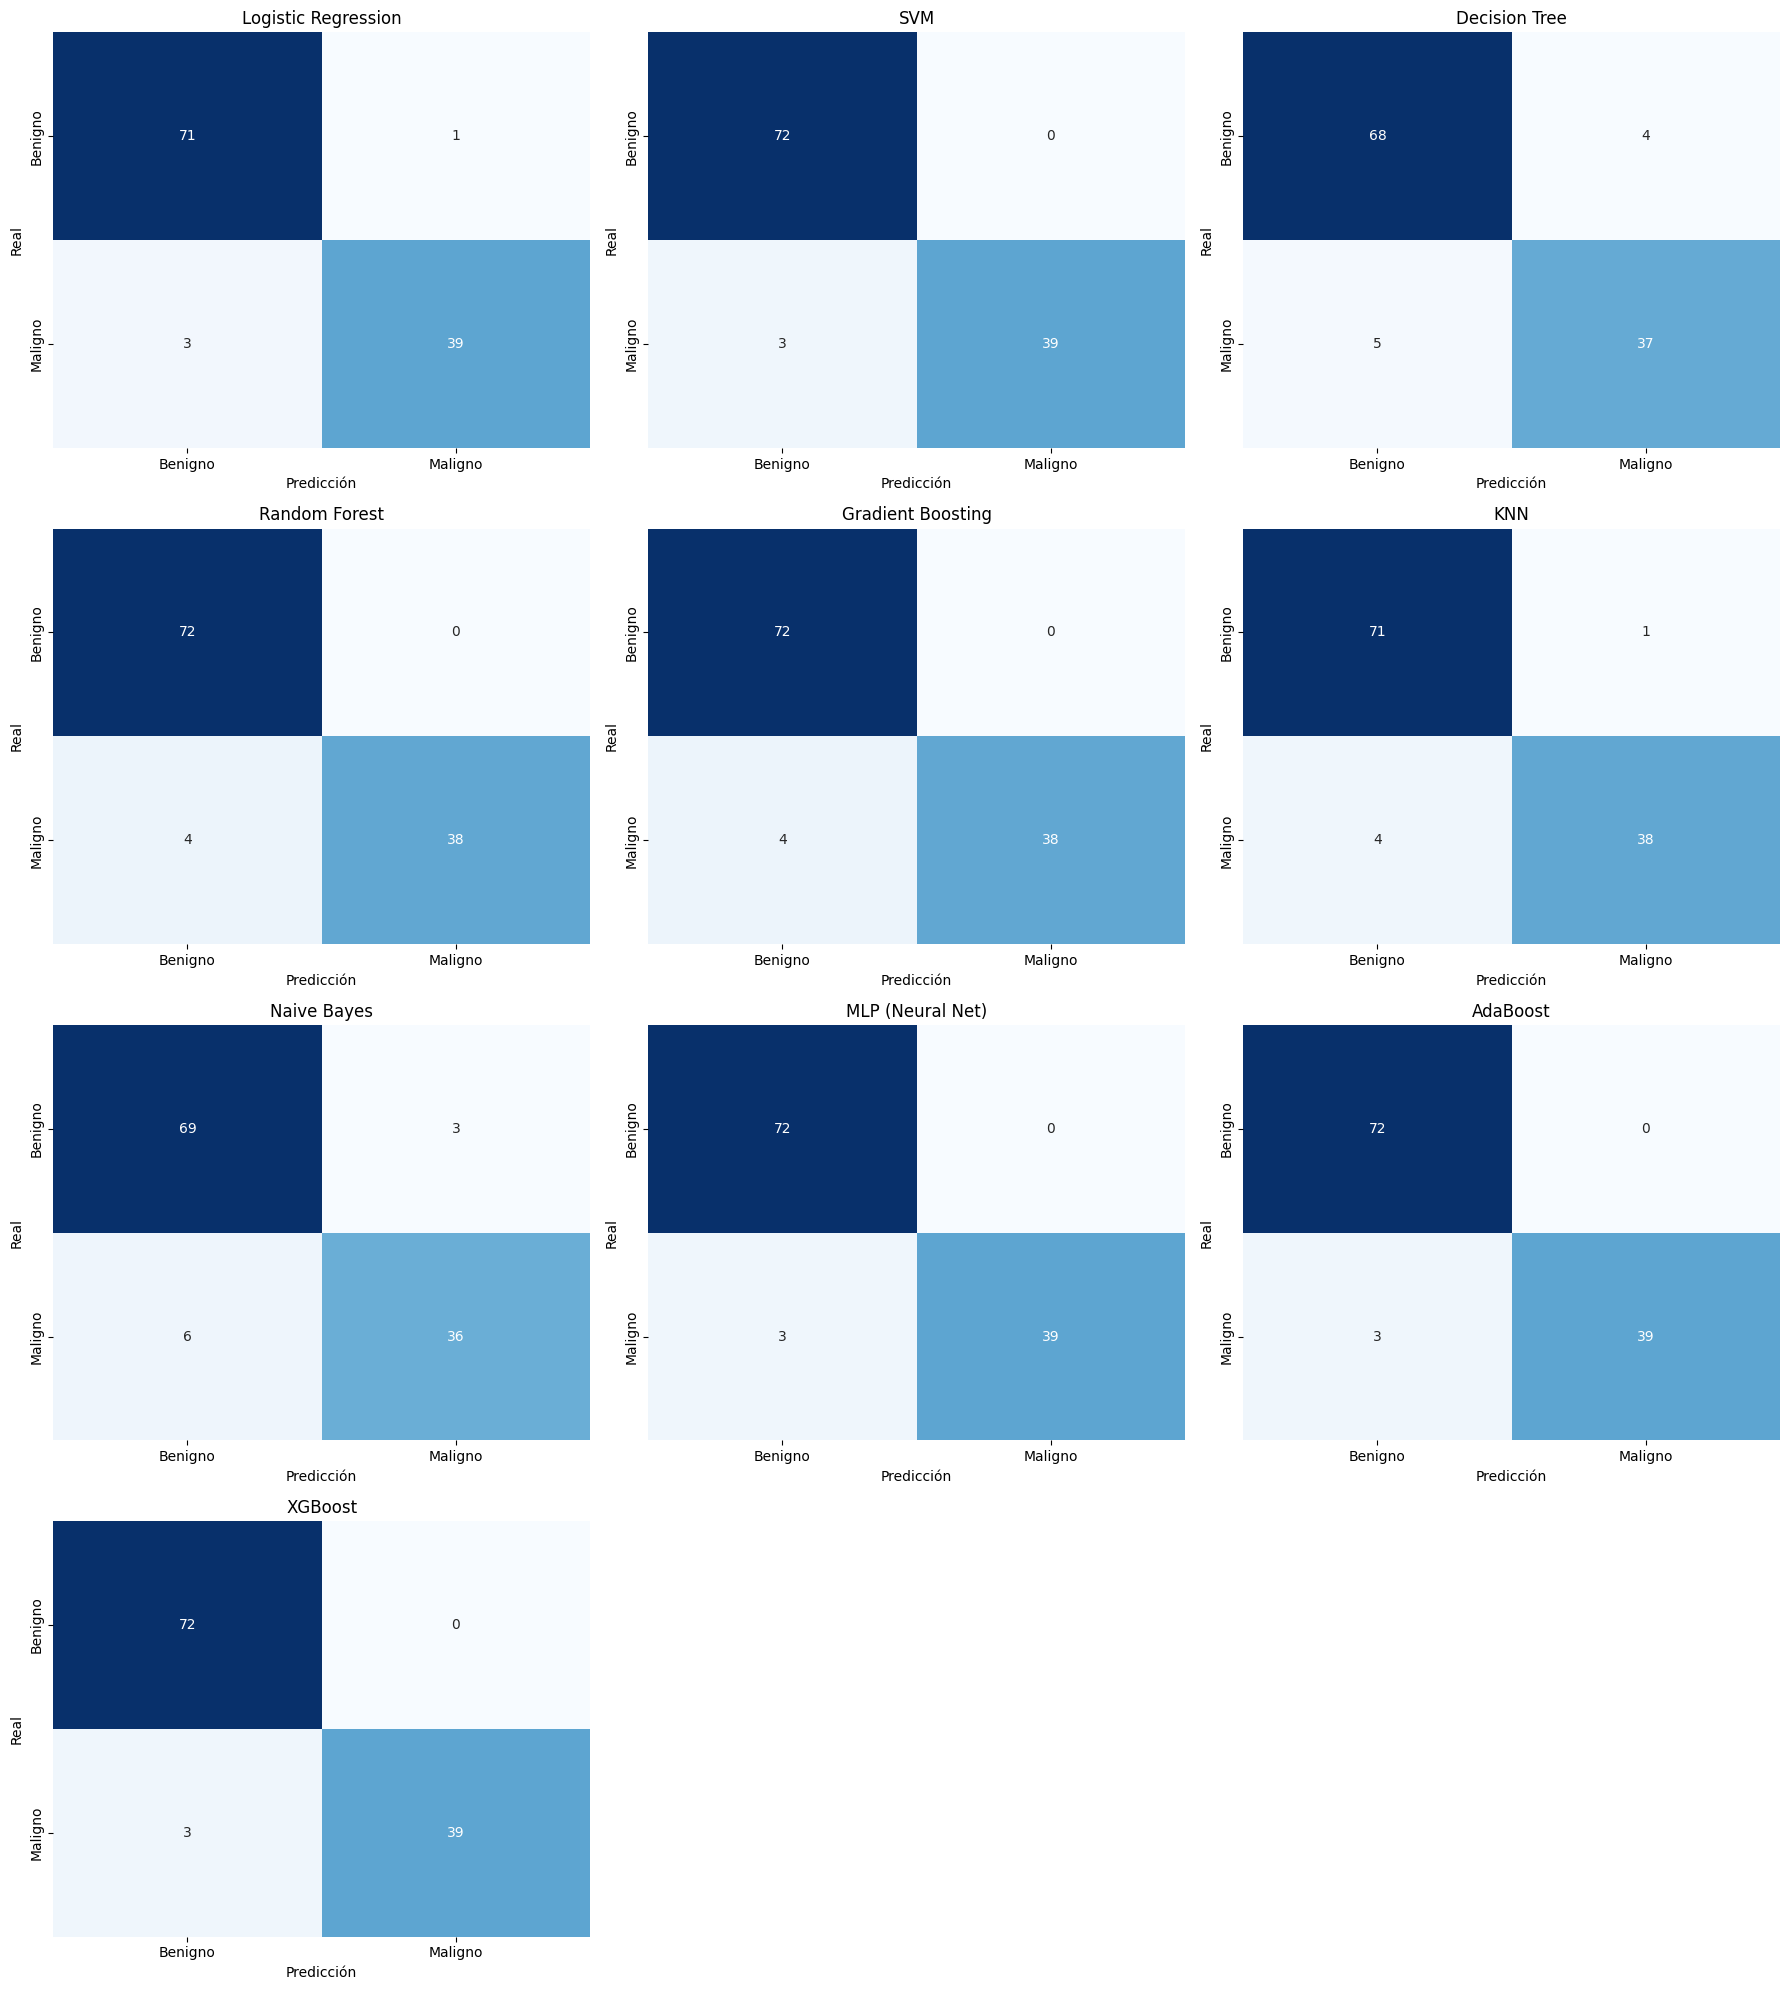

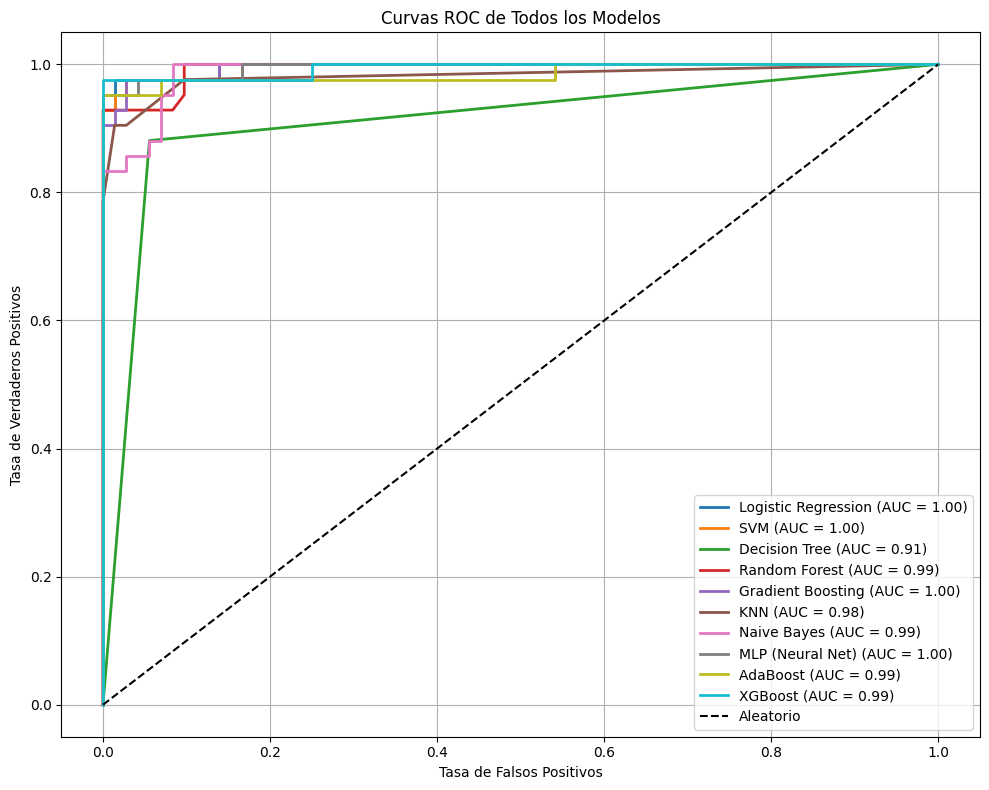

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
from google.colab import files

# ----------------------------------------
# 1. CARGA Y PREPROCESAMIENTO
# ----------------------------------------

# Cargar la base de datos.
df = pd.read_csv("Breast_Cancer_Database.csv")

# Eliminar columna 'id' si existe.
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

# # Convierte la variable categórica en valores numéricos(0 y 1). Benigno = 0 y Maligno = 1.
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])

# Separar las variables predictoras(X) y la variable objetivo(y).
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

# Escalado de las características.
# Media 0 y desviación estándar 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar el conjunto de datos en entrenamiento y test.
# 80% entrenamiento y 20% test.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------------------------------
# 2. ALGORITMOS DE CLASIFICACIÓN --- MODELO BASE(MB)
# -------------------------------------------------------

# Definición de los modelos de clasificación.
modelos_base = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss')
}

# Creación de las estructuras para almacenar los resultados.
matriz_confusion_MB = {}
metricas_MB = {}
curvas_roc_MB = {}

# Bucle para realizar el entrenamiento, predicción y evaluación de cada modelo.
for nombre, modelo in modelos_base.items():
    modelo.fit(X_train, y_train)             # Entrenamiento del modelo
    y_pred_class = modelo.predict(X_test)    # Predicción para el conjunto de test
    try:
        y_proba = modelo.predict_proba(X_test)[:, 1]
    except:
        y_proba = None

    # Generar un reporte con las métricas.
    report = classification_report(y_test, y_pred_class, output_dict=True)
    metricas_MB[nombre] = {
        "Accuracy": round(report['accuracy'], 3),
        "Precision (0)": round(report['0']['precision'], 3),     # Clase 0 = Benigno
        "Recall (0)": round(report['0']['recall'], 3),
        "F1-score (0)": round(report['0']['f1-score'], 3),
        "Precision (1)": round(report['1']['precision'], 3),     # Clase 1 = Maligno
        "Recall (1)": round(report['1']['recall'], 3),
        "F1-score (1)": round(report['1']['f1-score'], 3)
    }

    # Guardar matrices de confusión.
    matriz_confusion_MB[nombre] = confusion_matrix(y_test, y_pred_class)

    # Guardar datos de curvas ROC y AUC.
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc_MB = auc(fpr, tpr)
        curvas_roc_MB[nombre] = (fpr, tpr, roc_auc_MB)

# Convierte las métricas a DataFrame y se ordenan por Accuracy.
metricas_df_MB = pd.DataFrame(metricas_MB).T.sort_values(by="Accuracy", ascending=False)

# Guarda y exporta las métricas del modelo base en un Excel.
metricas_df_MB.to_excel("tabla_metricas_MB.xlsx")
files.download("tabla_metricas_MB.xlsx")

# Representación de las matrices de confusión de todos los modelos.
n = len(matriz_confusion_MB)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.ravel()
for i, (model_name, cm) in enumerate(matriz_confusion_MB.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(model_name)
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")
    axes[i].set_xticklabels(["Benigno", "Maligno"])
    axes[i].set_yticklabels(["Benigno", "Maligno"])
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

# Representación de las curvas ROC de todos los modelos en un mismo gráfico.
plt.figure(figsize=(10, 8))
for nombre, (fpr, tpr, roc_auc_MB) in curvas_roc_MB.items():
    plt.plot(fpr, tpr, label=f"{nombre} (AUC = {roc_auc_MB:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Aleatorio")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curvas ROC de Todos los Modelos")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# GridSearchCV rápido sin regresiones puras. (Abreviado por tiempos de computación)
grid_searches = {
    "Logistic Regression": {"model": LogisticRegression(max_iter=500), "params": {"C": [1], "solver": ["lbfgs"]}},
    "SVM": {"model": SVC(probability=True), "params": {"C": [1], "kernel": ["rbf"]}},
    "Decision Tree": {"model": DecisionTreeClassifier(), "params": {"max_depth": [5]}},
    "Random Forest": {"model": RandomForestClassifier(), "params": {"n_estimators": [50], "max_depth": [10]}},
    "Gradient Boosting": {"model": GradientBoostingClassifier(), "params": {"n_estimators": [100]}},
    "KNN": {"model": KNeighborsClassifier(), "params": {"n_neighbors": [5]}},
    "Naive Bayes": {"model": GaussianNB(), "params": {}},
    "MLP (Neural Net)": {"model": MLPClassifier(max_iter=500), "params": {"hidden_layer_sizes": [(50,)], "activation": ["relu"]}},
    "AdaBoost": {"model": AdaBoostClassifier(), "params": {"n_estimators": [50]}},
    "XGBoost": {"model": xgb.XGBClassifier(eval_metric='logloss'), "params": {"n_estimators": [100]}}
}

# Creación de las estructuras para almacenar información de los parámetros.
impacto_parametros = []
mejores_parametros = []

# Bucle para recorrer todos los modelos y ejecutar GridSearchCV.
for nombre, mp in grid_searches.items():
    modelo = mp["model"]                    # Modelo a entrenar
    param_grid = mp["params"]               # Hiperparámetros definidos para ese modelo

    # GridSearchCV realiza una búsqueda de combinaciones de hiperparámetros.
    grid = GridSearchCV(modelo, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)       # Entrena y evalua los hiperparámetros marcados

    # Convierte los resultados del GridSearchCV en un DataFrame.
    resultados = pd.DataFrame(grid.cv_results_)
    resultados['model'] = nombre

    # Guarda los resultados obtenidos de los hiperparámetros
    impacto_parametros.append(resultados[['model', 'params', 'mean_test_score']])
    mejores_parametros.append({
        "Modelo": nombre,
        "Mejores Hiperparámetros": grid.best_params_ if grid.best_params_ else "Default",
        "Accuracy CV": round(grid.best_score_, 4)
    })

# Guarda los mejores hiperparámetros en un Excel.
mejores_modelos_df = pd.DataFrame(mejores_parametros).sort_values(by="Accuracy CV", ascending=False)
mejores_modelos_df.to_excel("resumen_mejores_hiperparametros.xlsx", index=False)
files.download("resumen_mejores_hiperparametros.xlsx")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

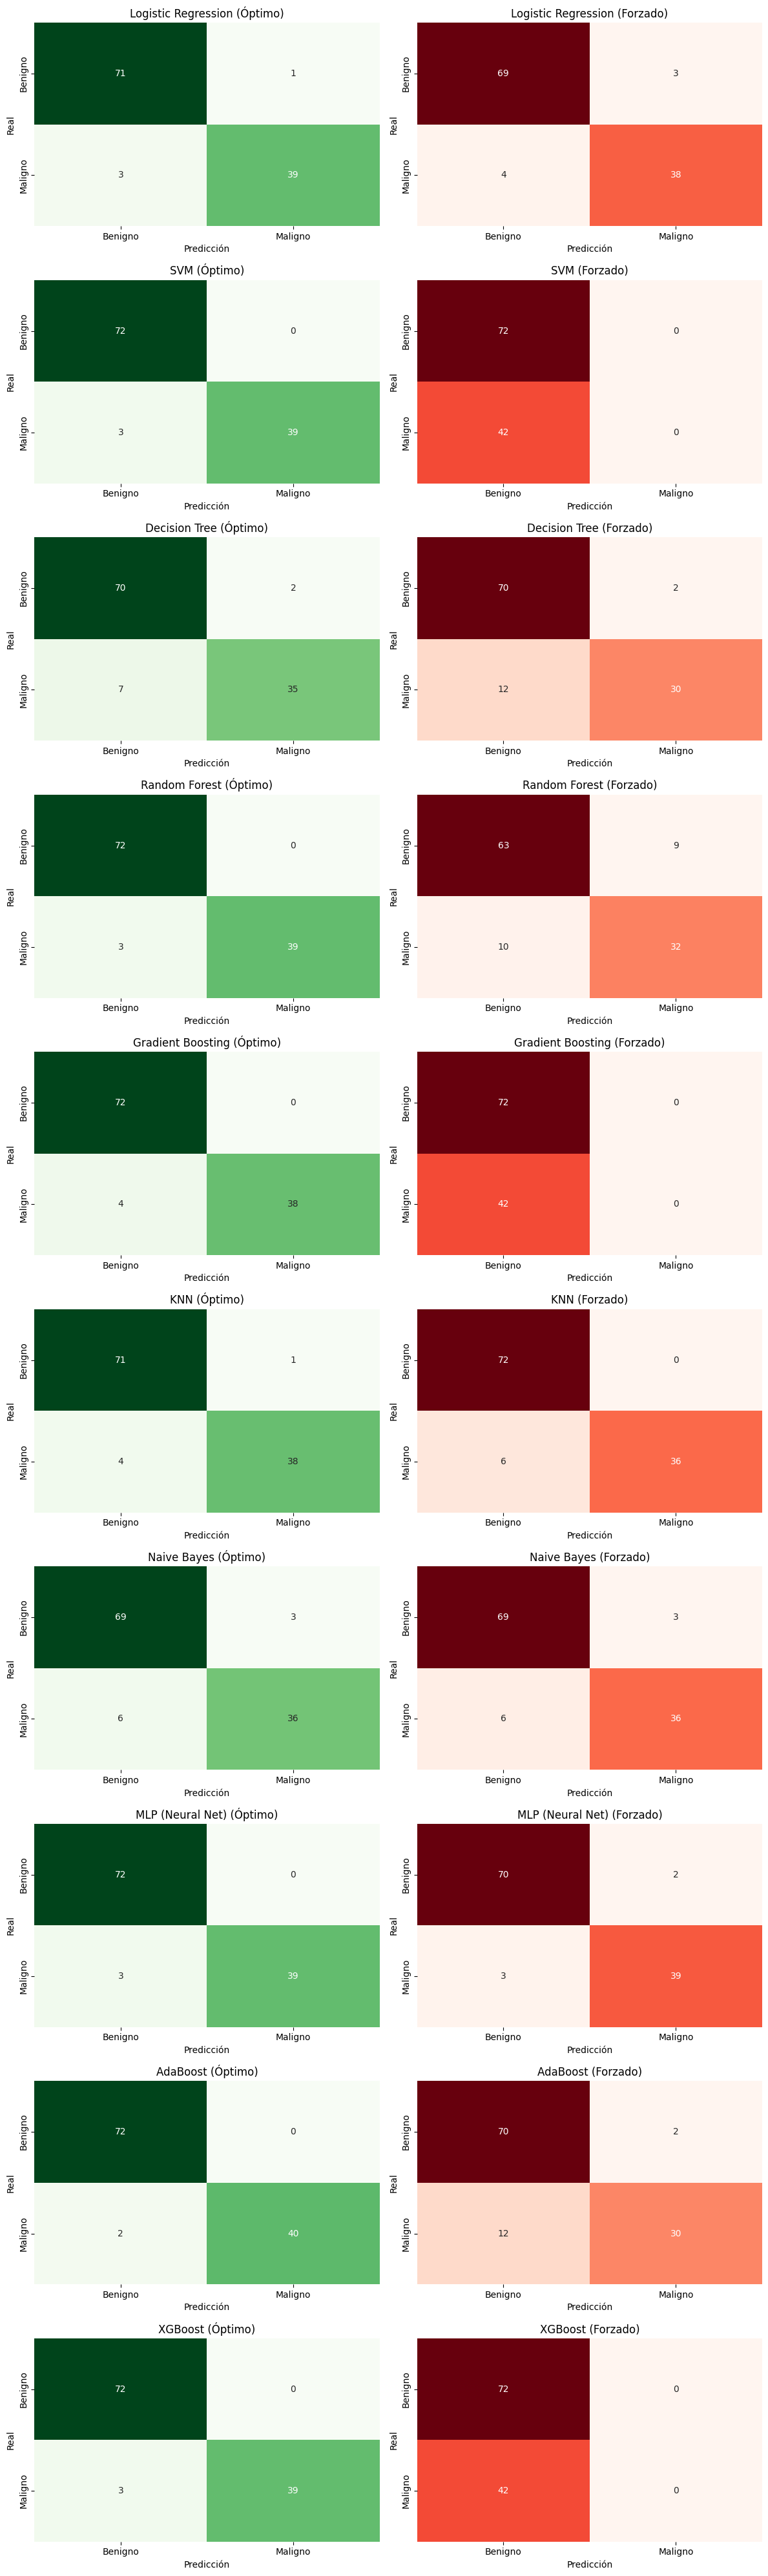

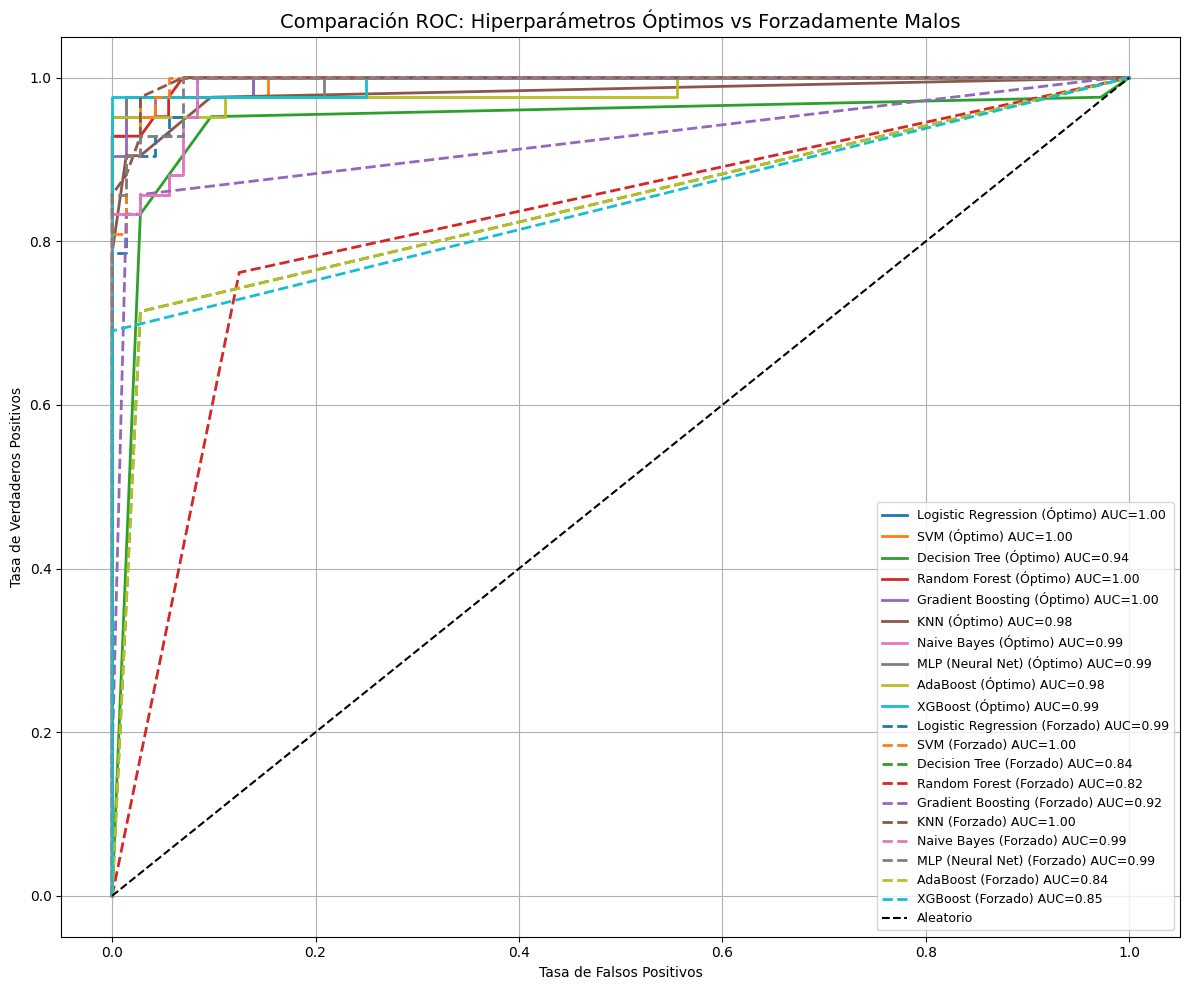

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from google.colab import files

# -------------------------------------------------------
# 3. ALGORITMOS DE CLASIFICACIÓN --- MODELO ÓPTIMO(MO)
# -------------------------------------------------------

# Definición de los modelos de clasificación.
modelos_optimos = {
    "Logistic Regression": LogisticRegression(C=1, solver="lbfgs", max_iter=500),
    "SVM": SVC(C=1, kernel="rbf", probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(50,), activation="relu", max_iter=500),
    "AdaBoost": AdaBoostClassifier(n_estimators=50),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
}

# Creación de las estructuras para almacenar los resultados.
curvas_roc_MO = {}
metricas_MO = {}
matriz_confusion_MO = {}

# Bucle para realizar el entrenamiento, predicción y evaluación de cada modelo.
for nombre, modelo in modelos_optimos.items():
    modelo.fit(X_train, y_train)                   # Entrenamiento del modelo
    y_pred = modelo.predict(X_test)                # Predicción para el conjunto de test
    try:
        y_proba = modelo.predict_proba(X_test)[:, 1]
    except:
        y_proba = None

    # Generar un reporte de las métricas.
    report = classification_report(y_test, y_pred, output_dict=True)
    metricas_MO[nombre] = {
        "Accuracy": round(report['accuracy'], 3),
        "Precision (0)": round(report['0']['precision'], 3),    # Clase 0 = Benigno
        "Recall (0)": round(report['0']['recall'], 3),
        "F1-score (0)": round(report['0']['f1-score'], 3),
        "Precision (1)": round(report['1']['precision'], 3),    # Clase 1 = Maligno
        "Recall (1)": round(report['1']['recall'], 3),
        "F1-score (1)": round(report['1']['f1-score'], 3)
    }

    # Guardar matrices de confusión.
    matriz_confusion_MO[nombre] = confusion_matrix(y_test, y_pred)

    # Guardar datos de curvas ROC y AUC.
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc_MO = auc(fpr, tpr)
        curvas_roc_MO[nombre] = (fpr, tpr, roc_auc_MO)

# Convierte las métricas a DataFrame y se ordenan por Accuracy.
metricas_df_MO = pd.DataFrame(metricas_MO).T.sort_values(by="Accuracy", ascending=False)

# Guarda y exporta las métricas del modelo óptimo  en un Excel.
metricas_df_MO.to_excel("tabla_metricas_MO.xlsx")
files.download("tabla_metricas_MO.xlsx")


# -------------------------------------------------------
# 4. ALGORITMOS DE CLASIFICACIÓN --- MODELO FORZADO(MF)
# -------------------------------------------------------

# Definición de los modelos de clasificación.
modelos_forzados = {
    "Logistic Regression": LogisticRegression(C=1e-5, solver="liblinear", max_iter=100),
    "SVM": SVC(C=1e-5, kernel="linear", probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=1),
    "Random Forest": RandomForestClassifier(n_estimators=1, max_depth=1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=1, learning_rate=0.01),
    "KNN": KNeighborsClassifier(n_neighbors=30),
    "Naive Bayes": GaussianNB(),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(5,), activation="identity", max_iter=100),
    "AdaBoost": AdaBoostClassifier(n_estimators=1, learning_rate=0.1),
    "XGBoost": xgb.XGBClassifier(n_estimators=1, max_depth=1, learning_rate=0.01, eval_metric='logloss')
}

# Creación de las estructuras para almacenar los resultados.
metricas_MF = {}
curvas_roc_MF = {}
matriz_confusion_MF = {}

# Bucle para realizar el entrenamiento, predicción y evaluación de cada modelo.
for nombre, modelo in modelos_forzados.items():
    modelo.fit(X_train, y_train)                  # Entrenamiento del modelo
    y_pred = modelo.predict(X_test)               # Predicción para el conjunto de test
    try:
        y_proba = modelo.predict_proba(X_test)[:, 1]
    except:
        y_proba = None

    # Generar un reporte con las métricas.
    report = classification_report(y_test, y_pred, output_dict=True)
    metricas_MF[nombre] = {
        "Accuracy": round(report['accuracy'], 3),
        "Precision (0)": round(report['0']['precision'], 3),     # Clase 0 = Benigno
        "Recall (0)": round(report['0']['recall'], 3),
        "F1-score (0)": round(report['0']['f1-score'], 3),
        "Precision (1)": round(report['1']['precision'], 3),     # Clase 1 = Maligno
        "Recall (1)": round(report['1']['recall'], 3),
        "F1-score (1)": round(report['1']['f1-score'], 3)
    }

    # Guardar matrices de confusión.
    matriz_confusion_MF[nombre] = confusion_matrix(y_test, y_pred)

    # Guardar datos de curvas ROC y AUC.
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc_MF = auc(fpr, tpr)
        curvas_roc_MF[nombre] = (fpr, tpr, roc_auc_MF)

# Convierte las métricas a DataFrame y se ordenan por Accuracy.
metricas_df_MF = pd.DataFrame(metricas_MF).T.sort_values(by="Accuracy", ascending=True)

# Guarda y exporta las métricas del modelo forzado en un Excel.
metricas_df_MF.to_excel("tabla_metricas_MF.xlsx")
files.download("tabla_metricas_MF.xlsx")




# Representación de las matrices de confusión de todos los modelos comparando óptimo vs forzado.
fig, axes = plt.subplots(len(matriz_confusion_MO), 2, figsize=(12, 4 * len(matriz_confusion_MO)))
nombre_modelos = list(matriz_confusion_MO.keys())

for i, nombre in enumerate(nombre_modelos):
    sns.heatmap(matriz_confusion_MO[nombre], annot=True, fmt='d', cmap='Greens', ax=axes[i, 0], cbar=False)
    axes[i, 0].set_title(f"{nombre} (Óptimo)")
    axes[i, 0].set_xlabel("Predicción")
    axes[i, 0].set_ylabel("Real")
    axes[i, 0].set_xticklabels(["Benigno", "Maligno"])
    axes[i, 0].set_yticklabels(["Benigno", "Maligno"])

    sns.heatmap(matriz_confusion_MF[nombre], annot=True, fmt='d', cmap='Reds', ax=axes[i, 1], cbar=False)
    axes[i, 1].set_title(f"{nombre} (Forzado)")
    axes[i, 1].set_xlabel("Predicción")
    axes[i, 1].set_ylabel("Real")
    axes[i, 1].set_xticklabels(["Benigno", "Maligno"])
    axes[i, 1].set_yticklabels(["Benigno", "Maligno"])

plt.tight_layout()
plt.show()

# Representación de las curvas ROC de todos los modelos en un mismo gráfico comparando óptimo vs forzado.
plt.figure(figsize=(12, 10))

for nombre, (fpr, tpr, roc_auc_MO) in curvas_roc_MO.items():
    plt.plot(fpr, tpr, linestyle='-', label=f"{nombre} (Óptimo) AUC={roc_auc_MO:.2f}", linewidth=2)

for nombre, (fpr, tpr, roc_auc_MF) in curvas_roc_MF.items():
    plt.plot(fpr, tpr, linestyle='--', label=f"{nombre} (Forzado) AUC={roc_auc_MF:.2f}", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label="Aleatorio")
plt.title("Comparación ROC: Hiperparámetros Óptimos vs Forzadamente Malos", fontsize=14)
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()